<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/COMPAS_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")
import os
import random
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

# Load SHAP_ERROR_DATA

In [230]:
Shap_error_data = pd.read_csv('/content/Shap_error_data.csv')
Shap_error_data.info()
features = Shap_error_data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP'], axis=1)

#print(Shap_error_data.loc[3])
#print(Shap_error_data.isna().sum())
len(Shap_error_data.index)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         5050 non-null   float64
 1   priors_count                5050 non-null   float64
 2   sex_Female                  5050 non-null   float64
 3   sex_Male                    5050 non-null   float64
 4   race_African-American       5050 non-null   float64
 5   race_Asian                  5050 non-null   float64
 6   race_Caucasian              5050 non-null   float64
 7   race_Hispanic               5050 non-null   float64
 8   race_Native American        5050 non-null   float64
 9   race_Other                  5050 non-null   float64
 10  Shap_age                    5050 non-null   float64
 11  Shap_priors_count           5050 non-null   float64
 12  Shap_sex_Female             5050 non-null   float64
 13  Shap_sex_Male               5050 

5050

# Preprocessing: Initialize / scaling dataset

In [231]:
'''
def initialize_dataset (data, with_errors = True, just_features = True, scale_features = True, with_classes = True):
  #input is the original dataset, whether errors are included, only features should be used, to scale the features, class labels are included
  #Initialisation of the dataset. Scales the features and errors, which can be included or exluded for clustering
  #it returns a scaled dataset with new columns "clusters" = 0 and "new_clusters" = -1, which is required for HBAC

  new_data = data.copy(deep=True)

  if with_errors:
    scaling_factor = 0.8  # default scaling factor - there is a trade-off between scaling of weighing the errors to guide biased clusters while preventing too large and uninformative clusters
    new_data['scaled_TP'] = new_data['TP'] * scaling_factor
    new_data['scaled_TN'] = new_data['TN'] * scaling_factor
    new_data['scaled_FN'] = new_data['FN'] * scaling_factor
    new_data['scaled_FP'] = new_data['FP'] * scaling_factor

  if just_features:
    new_data = new_data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP'], axis=1)

  if scale_features:
    to_scale = data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP'], axis=1).columns
    new_data[to_scale] = StandardScaler().fit_transform(features[to_scale])

  if with_classes:
    for col in ['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP']:
      new_data[col] = data[col]


    new_data['clusters'] = 0
    new_data['new_clusters'] = -1
  return new_data

  '''

def initialize_dataset(data, with_errors=True, just_features=True, scale_features=True, with_classes=True):
    new_data = data.copy(deep=True)

    if with_errors:
        scaling_factor = 0.8
        error_columns = ['TP', 'TN', 'FN', 'FP']
        new_data[error_columns] = new_data[error_columns] * scaling_factor

    if just_features:
        new_data = new_data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type'], axis=1)

    if scale_features:
        numeric_columns = new_data.select_dtypes(include=['number']).columns
        scaler = StandardScaler()
        new_data[numeric_columns] = scaler.fit_transform(new_data[numeric_columns])

    if with_classes:
        new_data['clusters'] = 0
        new_data['new_clusters'] = -1

    return new_data



In [232]:
initialize_dataset(Shap_error_data)

Shap_error_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         5050 non-null   float64
 1   priors_count                5050 non-null   float64
 2   sex_Female                  5050 non-null   float64
 3   sex_Male                    5050 non-null   float64
 4   race_African-American       5050 non-null   float64
 5   race_Asian                  5050 non-null   float64
 6   race_Caucasian              5050 non-null   float64
 7   race_Hispanic               5050 non-null   float64
 8   race_Native American        5050 non-null   float64
 9   race_Other                  5050 non-null   float64
 10  Shap_age                    5050 non-null   float64
 11  Shap_priors_count           5050 non-null   float64
 12  Shap_sex_Female             5050 non-null   float64
 13  Shap_sex_Male               5050 

## Clustering on either TP/FN or TN/FP --> drop 0,0 rows

In [233]:
##Drop rows where both TP and FN are zero
def drop_zero_TP_FN(data):
    return data.loc[(data['TP'] == 1) | (data['FN'] == 1)]

TP_FN_data = drop_zero_TP_FN(Shap_error_data)


################################################

#Drop rows where both TN and FP are zero

def drop_zero_TN_FP(data):
    return data.loc[(data['TN'] == 1) | (data['FP'] == 1)]

TN_FP_data = drop_zero_TN_FP(Shap_error_data)

################################################
if ((TP_FN_data['TP'] == 0) & (TP_FN_data['FN'] == 0)).any():
    print("There's at least one occurrence of TP 0 and FN 0 in the dataset.")
else:
    print("There's no occurrence of 0,0 in both columns TP and FN.")

if ((TN_FP_data['TN'] == 0) & (TN_FP_data['FP'] == 0) ).any():
    print("There's at least one occurrence of TP 0 and FN 0 in the dataset.")
else:
    print("There's no occurrence of 0,0 in both columns TN and FP.")

There's no occurrence of 0,0 in both columns TP and FN.
There's no occurrence of 0,0 in both columns TN and FP.


In [234]:
#TP_FN_data.info()
TN_FP_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1955 entries, 0 to 5049
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         1955 non-null   float64
 1   priors_count                1955 non-null   float64
 2   sex_Female                  1955 non-null   float64
 3   sex_Male                    1955 non-null   float64
 4   race_African-American       1955 non-null   float64
 5   race_Asian                  1955 non-null   float64
 6   race_Caucasian              1955 non-null   float64
 7   race_Hispanic               1955 non-null   float64
 8   race_Native American        1955 non-null   float64
 9   race_Other                  1955 non-null   float64
 10  Shap_age                    1955 non-null   float64
 11  Shap_priors_count           1955 non-null   float64
 12  Shap_sex_Female             1955 non-null   float64
 13  Shap_sex_Male               1955 

In [235]:
len(TP_FN_data)
#len(TN_FP_data)
#len(Shap_error_data)


1579

# PCA
needs to be separated still for TN/FP and TP/FN

In [236]:
def pca_plot(data, title, alpha):

    #extract features for PCA and drop the other columns in other_features df
    pca_features = data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type'], axis=1)
    other_features = data[['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type']]

    # Scale the PCA features before using PCA
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(pca_features)

    # Apply PCA with 2 components to scaled features and create a df for the resulting principal components
    pca_result = PCA(n_components=2).fit_transform(scaled_features)
    pca_df = pd.DataFrame(pca_result, index=pca_features.index)

    #create temporary dataset that contains both principal components and other features
    temp_dataset = pca_df.join(other_features, how='left')
    temp_dataset.rename(columns={0: 'Principal Component 1', 1: 'Principal Component 2'}, inplace=True)

    scatterplot = sns.scatterplot(data=temp_dataset,x ='Principal Component 1', y='Principal Component 2', alpha=alpha, hue="Error_Type", palette="tab10", style="Error_Type")

    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = PCA(n_components=2).fit(scaled_features).explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()


#Clustering Functions

In [237]:
#Calculate accuracy on error
#def accuracy_error (results, error = ['FN']):
def accuracy_error (results, error =None):
  if len(results) == 0:
    print ("you are calculating the accuracy on an empty cluster")
  correct = results.loc[results[error] == 0]
  #correct = results.loc[results['FN'] == 0]
  acc = len(correct)/ len(results)
  return acc

#################################

#Calculate bias based on accuracy_error function

'''Calculate bias: negative bias as the accuracy of a selected cluster - accruacy of the remaining clusters
 Colster col: name of the DF column where the cluster assignments are'''

def bias_w_error (data, cluster_id, cluster_col):
  cluster_x = data.loc[data[cluster_col] == cluster_id]
  if len(cluster_x) ==0:
    print("this is an empty cluster", cluster_id)
  remaining_clusters = data.loc[data[cluster_col] != cluster_id]
  if len(remaining_clusters) ==0:
    print ("This cluster is the entire dataset. Cluster:", cluster_id)
  return accuracy_error(cluster_x) - accuracy_error(remaining_clusters)

#################################

#Combined function for get_max_neg_bias and get_max_pos_bias

def get_max_bias(data, bias_type = 'negative', function = bias_w_error):
  max_bias = float('inf') if bias_type == 'negative' else -float('inf') #initializes max_bias with either positive of negative infinity (special floating point value) based on bias_type param
  for cluster_number in data['new_clusters'].unique():
    if cluster_number == -1:#outliers in dbscan
      continue
    current_bias = function(data, cluster_number, 'new_clusters') #for each cluster the bias_w_error function is calculated
    if (bias_type == 'negative' and current_bias < max_bias) or (bias_type == 'positive' and current_bias > max_bias):
      max_bias = current_bias
  print(f'Maximum {bias_type} bias is:', max_bias)
  return max_bias


###################################
#get max bias cluster --> returns a cluster with neg bias (for newly added clusters)

def get_cluster_max_bias(data, function = bias_w_error):
  max_pos_bias = 100 #max_abs bias selma code
  max_bias_cluster = -2
  for cluster_number in data['clusters'].unique():
    if cluster_number == -1:
      continue
    current_bias = (function(data, cluster_number, 'clusters')) #pos function to find the highest bias
    print(f"{cluster_number} has bias {current_bias}")
    if current_bias < max_pos_bias:
      max_pos_bias = current_bias
      max_bias_cluster = cluster_number
  print ('cluster with the highest discriminating bias:', max_bias_cluster)
  return max_bias_cluster

#################################

#Select a new cluster to split on based on the smallest absolute difference from the overall error rate of 0.5
#Function requires a df.columns named 'clusters' and 'FP'

def select_new_cluster(data, error_column=None, overall_error_rate=0.5):
    smallest_diff = 1
    selected_cluster = None

    if error_column is None:
        error_column = 'FP'  # Default to 'FP' if error_column is not specified

    for cluster_number in data['clusters'].unique():
        if cluster_number == -1:
            continue
        cluster_data = data[data['clusters'] == cluster_number]
        cluster_error_rate = cluster_data[error_column].mean()  # Use specified error column
        abs_diff = abs(overall_error_rate - cluster_error_rate)

        if abs_diff < smallest_diff:
            smallest_diff = abs_diff
            selected_cluster = cluster_number

    return selected_cluster

#############################################
#Calculate variance

def calculate_variance(data):
  variance_list_local = []
  for j in data['clusters'].unique():
    average_acc = accuracy_error(data)
    bias_clus = bias_w_error(data, j, 'clusters')
    variance_list_local.append(bias_clus)
  variance = np.variance(variance_list_local)
  return variance

#calculate bias_acc_global

def calculate_bias_global_average(data, cluster_id, cluster_col, ave_acc):
  cluster_x = data.loc[data[cluster_col] == cluster_id]
  return accuracy_error(cluster_x) - ave_acc

#############################################

#Get min splittable cluster size - returns size of smallest new cluster
def min_split_cluster_size(data):
  min_cluster_size = len(data)
  for i in data['new_clusters'].unique():
    if i == -1:
      continue
    size = len(data.loc[data['new_clusters']==i])
    if size < min_cluster_size:
      min_cluster_size = size
  return min_cluster_size

#################################################


#Select a random cluster from provided list of clusters that is not -1
def get_random_cluster(clusters):
  result = -1
  while (result == -1):
    result = random.randint(0, len(clusters.unique()))
  print('This is the random cluster we picked:', result)
  return result

#############################################

#Plot cluster
def plot_clusters(data):
  scatterplot = sns.scatterplot(data=data, x='1st', y='2nd', hue="clusters", size = 'errors', sizes=(100, 20), palette = "tab10")
  plt.show()


# Determining the epsilon parameter using the K-Distance plot

Using the k-distance plot to determine epsilon by identifying the knee point (where there is a significant increese

32

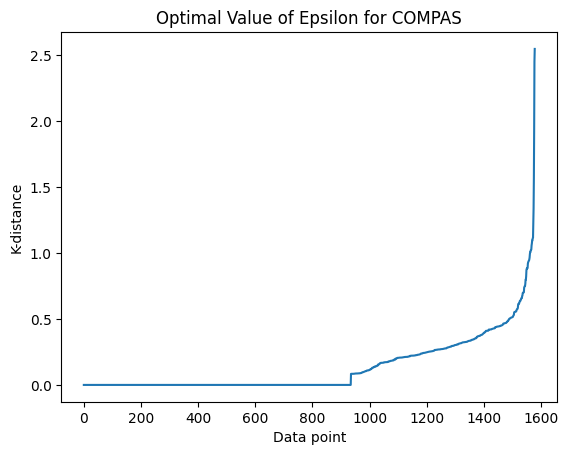

In [238]:
nn_features = TP_FN_data.iloc[:, : 11]

neigh = NearestNeighbors(n_neighbors = 3) # compute distance to 2nd nearest neighbor (k=3) for each data point
nbrs = neigh.fit(nn_features)
distances, indices = nbrs.kneighbors(nn_features)

distances = np.sort(distances, axis= 0)
distances = distances [:,1]
plt.plot(distances)
plt.xlabel('Data point')
plt.ylabel('K-distance')
plt.title("Optimal Value of Epsilon for COMPAS")

round(0.02 * len(TP_FN_data)) #decide on min nr points for dbscan?

#DBSCAN clustering

Explained Variance Ratio: PC1 = 0.14, PC2 = 0.11


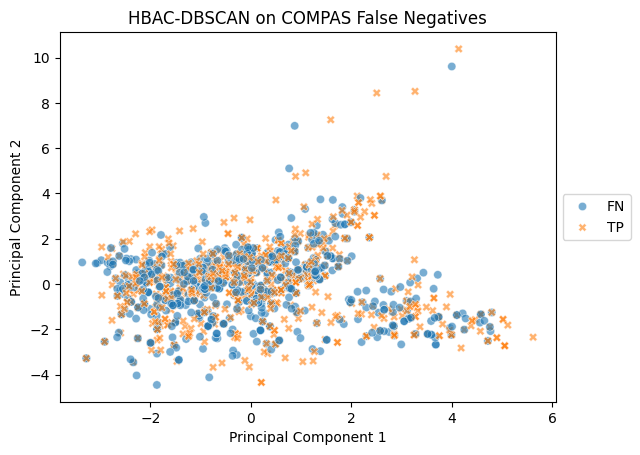

MAX_ITER
0.5250158328055732
[]


In [240]:
#TP_FN_data

variance_list = []
acc = accuracy_error(TP_FN_data, error = 'FN')
pca_plot(TP_FN_data,'HBAC-DBSCAN on COMPAS False Negatives', 0.6) #change this for TN FP data

def bias_with_error_rate_FN(data = TP_FN_data, input_columns = features, error_column = 'FN', max_iter=30, min_splittable_cluster_size = 5, min_acceptable_cluster_size = 5, dbscan_max_iter=100,
                         eps = 0.5, min_samples = 32, x = 0, initial_bias = 0):
  for i in range(1, max_iter):
    print('This is the current cluster: ', x)
    eps = eps + 0.001
    if len(data['clusters'].unique()) != 1:
      variance_list.append(calculate_variance(data))

    data['new_clusters'] = -2
    candidate_cluster = data.loc[data['clusters'] == x]

    if len(candidate_cluster) < min_splittable_cluster_size:
      x = get_random_cluster(data['clusters'])
      continue

  #apply DBSCAN
  candidate_cluster['new_cluster'] = pd.DataFrame(DBSCAN(eps = 0.5, min_samples = 39).fit_predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class',
                                                                                                                                   'errors', 'TP', 'TN', 'FN', 'FP'], axis=1)), index= candidate_cluster.index)
  data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(data['new_clusters'])

  if (len(data['new_clusters'].unique()) <= 2):
    max_bias = get_max_bias(data, bias_type = 'negative')
    min_cluster_size = min_split_cluster_size(data)
    print('smallest cluster: ', min_cluster_size)


  if (max_bias <= initial_bias) & (min_cluster_size > min_acceptable_cluster_size):
    #add new cluster
    n_cluster = max(data['clusters'])
    #print(data['new_clusters'])

    first = True
    dif = 1
    for clstr in data['new_clusters'].unique():
      if (clstr == -1):
        data['clusters'][data['new_clusters'] == clstr] = -1
      elif (clstr == -2):
        continue
      elif first:
        data['clusters'][data['new_clusters'] == clstr] = x
        first = False
      else:
        data['clusters'][data['new_clusters'] == clstr] =  n_cluster + dif
        dif += 1

      pca_plot(data, 'HBAC-DBSCAN on COMPAS', 0.6)
      x = select_new_cluster(data, error_column = 'FN')
      initial_bias = max_bias
    else:
        x = get_random_cluster(data['clusters'])

print('MAX_ITER')
print(acc)
print(variance_list)

39

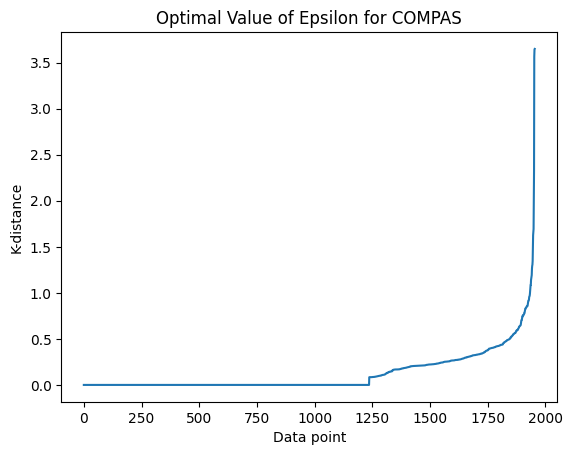

In [241]:
nn_features = TN_FP_data.iloc[:, : 11]

neigh = NearestNeighbors(n_neighbors = 3) # compute distance to 2nd nearest neighbor (k=3) for each data point
nbrs = neigh.fit(nn_features)
distances, indices = nbrs.kneighbors(nn_features)

distances = np.sort(distances, axis= 0)
distances = distances [:,1]
plt.plot(distances)
plt.xlabel('Data point')
plt.ylabel('K-distance')
plt.title("Optimal Value of Epsilon for COMPAS")

round(0.02 * len(TN_FP_data)) #decide on min nr points for dbscan?

Explained Variance Ratio: PC1 = 0.15, PC2 = 0.12


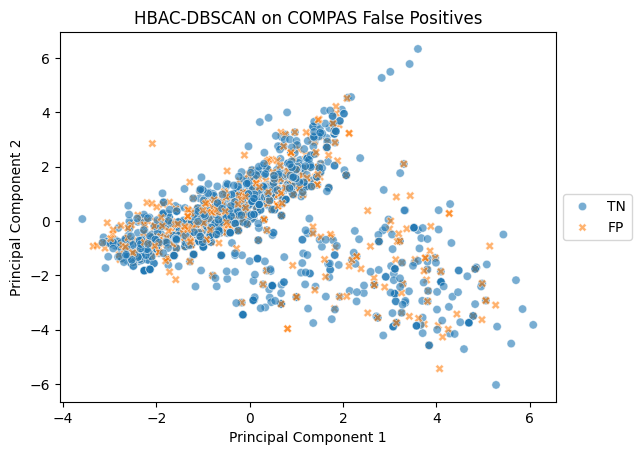

MAX_ITER
0.668542199488491
[]


In [242]:
#TN_FP_data

variance_list = []
acc = accuracy_error(TN_FP_data, error = 'FP')
pca_plot(TN_FP_data,'HBAC-DBSCAN on COMPAS False Positives', 0.6) #change this for TN FP data

def bias_with_error_rate_FP(data = TN_FP_data, input_columns = features, error_column = 'FP', max_iter=30, min_splittable_cluster_size = 5, min_acceptable_cluster_size = 5, dbscan_max_iter=100,
                         eps = 0.5, min_samples = 39, x = 0, initial_bias = 0):
  for i in range(1, max_iter):
    print('This is the current cluster: ', x)
    eps = eps + 0.001
    if len(data['clusters'].unique()) != 1:
      variance_list.append(calculate_variance(data))

    data['new_clusters'] = -2
    candidate_cluster = data.loc[data['clusters'] == x]

    if len(candidate_cluster) < min_splittable_cluster_size:
      x = get_random_cluster(data['clusters'])
      continue

  candidate_cluster['new_cluster'] = pd.DataFrame(DBSCAN(eps = 0.5, min_samples = 39).fit_predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class',
                                                                                                                                   'errors', 'TP', 'TN', 'FN', 'FP'], axis=1)), index= candidate_cluster.index)
  data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(data['new_clusters'])

  if (len(data['new_clusters'].unique()) <= 2):
    max_bias = get_max_bias(data, bias_type = 'negative')
    min_cluster_size = min_split_cluster_size(data)
    print('smallest cluster: ', min_cluster_size)


  if (max_bias <= initial_bias) & (min_cluster_size > min_acceptable_cluster_size):
    #add new cluster
    n_cluster = max(data['clusters'])
    #print(data['new_clusters'])

    first = True
    dif = 1
    for clstr in data['new_clusters'].unique():
      if (clstr == -1):
        data['clusters'][data['new_clusters'] == clstr] = -1
      elif (clstr == -2):
        continue
      elif first:
        data['clusters'][data['new_clusters'] == clstr] = x
        first = False
      else:
        data['clusters'][data['new_clusters'] == clstr] =  n_cluster + dif
        dif += 1

      pca_plot(data, 'HBAC-DBSCAN on COMPAS', 0.6)
      x = select_new_cluster(data, error_column = 'FP')
      initial_bias = max_bias
    else:
        x = get_random_cluster(data['clusters'])

print('MAX_ITER')
print(acc)
print(variance_list)

